# 稳态转换的原因

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
from hydra import compose, initialize
import os

# 加载项目层面的配置
with initialize(version_base=None, config_path="../config"):
    cfg = compose(config_name="config")
os.chdir(cfg.root)

In [3]:
# 加载必要的包
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
import matplotlib.colors
import sys
from matplotlib.gridspec import GridSpec

plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "out"
sys.path.append("..")
period_colors = ["#0889A6", "#F1801F", "#006C43"]


# 加载阈值为 0.05的数据，即与黄河流域相交面积大于全市总面积 5% 的所有市
city_yr = pd.read_csv(
    cfg.db.perfectures,
    index_col=0,
)

regions = city_yr["Region"].unique()
city_yr.shape
city_yr.head()

(2940, 59)

,Year,IRR,Irrigated area: Total,Irrigated area: Rice,Irrigated area: Wheat,Irrigated area: Maize,Irrigated area: Vegetables and fruits,Irrigated area: Others,Irrigation water-use intensity (WUI): Total,Irrigation water-use intensity (WUI): Rice,...,Rural domestic WUI,Rural livestock WU,Livestock population,Livestock WUI,Total water use,Province_n,Area_calcu,Region,Intersect_area,Ratio
City_ID,,,,,,,,,,,,,,,,,,,,,
C27,1965,0.300518,46.631997,0.391448,16.089679,1.152312,0.571298,28.427261,644.445209,965.436106,...,31.895556,0.003203,141.750766,0.022595,0.328586,Gansu,20091.467281,UR,19188.439369,0.955054
C27,1966,0.323595,49.468303,0.383836,16.485679,1.434736,0.636613,30.527440,654.146772,979.121070,...,28.371723,0.003336,147.646616,0.022592,0.351996,Gansu,20091.467281,UR,19188.439369,0.955054
C27,1967,0.340063,52.309331,0.416675,17.803304,1.442818,0.697033,31.949501,650.100439,973.012862,...,21.033715,0.003413,151.033245,0.022600,0.372432,Gansu,20091.467281,UR,19188.439369,0.955054
C27,1968,0.352690,53.870788,0.437429,18.863369,1.514685,0.770592,32.284713,654.695280,979.011409,...,22.233352,0.003487,154.266500,0.022604,0.391458,Gansu,20091.467281,UR,19188.439369,0.955054
C27,1969,0.365740,55.120730,0.447621,19.700679,1.549920,0.752680,32.669830,663.524461,992.248499,...,32.825618,0.003575,158.251492,0.022594,0.406136,Gansu,20091.467281,UR,19188.439369,0.955054


## 水库数据调用

In [4]:
reservoirs = pd.read_csv(cfg.db.clean_reservoirs)
cum_reservoirs = pd.read_csv(cfg.db.reservoirs, index_col=0).cumsum().loc[1965:2013]
reservoirs.head()
cum_reservoirs.head()

,年,容量,名称,省份,区域,枢纽
0,1958,40.000,东平湖围堤,山东省,DR,0
1,1959,2.160,盐锅峡,甘肃省,UR,1
2,1960,0.168,红领巾水库,河北省,DR,0
3,1961,7.230,汾河水库,山西省,MR,0
4,1962,2.570,巴家嘴水库,甘肃省,UR,0


,SR,UR,MR,DR
1965,0.0,4.73,7.23,113.368
1966,0.0,4.73,7.23,115.578
1967,0.0,12.08,7.23,115.578
1968,0.0,69.08,7.23,115.578
1969,0.0,69.08,7.23,115.578


/Users/songshgeo/Documents/VSCode/WGRegimes_YRB_2020/.venv/lib/python3.11/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/Users/songshgeo/Documents/VSCode/WGRegimes_YRB_2020/.venv/lib/python3.11/site-packages/matplotlib/collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


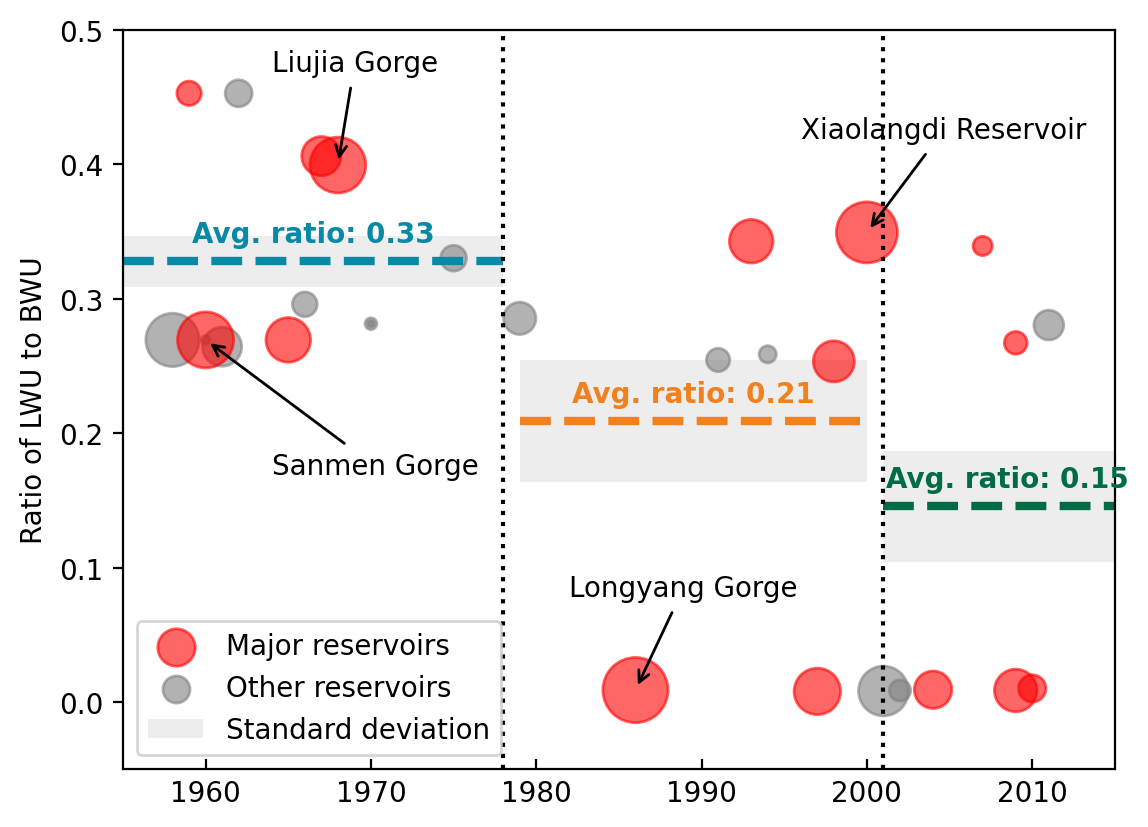

In [5]:
def get_region_wu(yr, region):
    region_wu = (
        city_yr.groupby(["Region", "Year"]).sum(numeric_only=True)["Total water use"]
        * 10
    )
    if yr in city_yr["Year"].unique():
        return region_wu[region][yr]
    elif yr <= 1965:
        return region_wu[region][1965]
    elif yr >= 2013:
        return region_wu[region][2013]


def get_all_wu(yr):
    wu = city_yr.groupby("Year")["Total water use"].sum(numeric_only=True) * 10
    if yr in city_yr["Year"].unique():
        return wu[yr]
    elif yr <= 1965:
        return wu[1965]
    elif yr >= 2013:
        return wu[2013]


def get_ratio_location(row):
    region = row["区域"]
    yr = row["年"]
    ratio = get_region_wu(yr, region) / get_all_wu(yr)
    return ratio


fig, ax = plt.subplots()


def plot_reservoirs(ax):
    reservoirs["ratio"] = reservoirs.apply(get_ratio_location, axis=1)
    hubs = reservoirs[reservoirs["枢纽"] == 1]
    not_hubs = reservoirs[reservoirs["枢纽"] == 0]
    scale = 100
    alpha = 0.6
    ax.scatter(
        x=hubs["年"],
        y=hubs["ratio"],
        s=np.log(hubs["容量"]) * scale,
        color="red",
        # label="枢纽水库",
        label="Major reservoirs",
        alpha=alpha,
        zorder=2,
    )
    ax.scatter(
        x=not_hubs["年"],
        y=not_hubs["ratio"],
        s=np.log(not_hubs["容量"]) * scale,
        color="gray",
        label="Other reservoirs",
        # label="其它水库",
        alpha=alpha,
        zorder=1,
    )

    #     ax.set_xlabel("Year")
    # ax.set_ylabel("区域用水占流域总用水比重")
    ax.set_ylabel("Ratio of LWU to BWU")

    # ========= 标注关键的水库 ========= #
    mask1 = reservoirs["枢纽"] == 1
    mask2 = reservoirs["容量"] > 20
    key_data = reservoirs[mask1 & mask2].copy()
    key_data["Eng_name"] = [
        "Liujia Gorge",
        "Longyang Gorge",
        "Sanmen Gorge",
        "Xiaolangdi Reservoir",
    ]
    key_data["Ch_name"] = ["刘家峡", "龙羊峡", "三门峡", "小浪底"]

    for row in key_data.itertuples(index=False):
        yr = row[0]
        ratio = row[6]
        # 7 是英文名，8是中文名
        en_name = row[7]
        name = row[8]
        if en_name == "Sanmen Gorge":
            ax.annotate(
                en_name,
                xy=(yr, ratio),
                xycoords="data",
                xytext=(yr + 4, ratio - 0.1),
                textcoords="data",
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
            )
        else:
            ax.annotate(
                en_name,
                xy=(yr, ratio),
                xycoords="data",
                xytext=(yr - 4, ratio + 0.07),
                textcoords="data",
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3"),
            )

    # =========== 每个阶段的平均值 =========== #
    ax.set_xlim(1955, 2015)
    ax.set_ylim(-0.05, 0.5)
    periods = [(1955, 1978), (1979, 2000), (2001, 2016)]
    periods_ratio_dict = {}  # 用来储存结果，检验显著性
    for i, period in enumerate(periods):
        start, end = period
        x_min, x_max = ax.get_xlim()
        y_min, y_max = ax.get_ylim()

        def get_y_ratio(x):
            return (x - y_min) / (y_max - y_min)

        start_ratio, end_ratio = (start - x_min) / (x_max - x_min), (end - x_min) / (
            x_max - x_min
        )
        data = reservoirs[(reservoirs["年"] < end) & (reservoirs["年"] >= start)]
        ratio = data["ratio"].mean()
        std = data["ratio"].std() / np.sqrt(len(data))
        periods_ratio_dict["{}-{}".format(start, end)] = data["ratio"]
        if i == 0:
            ax.axvspan(
                start,
                end,
                get_y_ratio(ratio - std),
                get_y_ratio(ratio + std),
                facecolor="lightgray",
                alpha=0.4,
                zorder=-1,
                # label="标准误差",
                label="Standard deviation",
            )
        else:
            ax.axvspan(
                start,
                end,
                get_y_ratio(ratio - std),
                get_y_ratio(ratio + std),
                facecolor="lightgray",
                alpha=0.4,
                zorder=-1,
            )
        ax.axhline(
            ratio,
            start_ratio,
            end_ratio,
            ls="--",
            lw=3,
            color=period_colors[i],
        )
        # note = f"平均值: {ratio:.2f}"
        note = f"Avg. ratio: {ratio:.2f}"
        ax.text(
            (start + end) / 2,
            ratio + 0.02,
            s=note,
            color=period_colors[i],
            weight="bold",
            ha="center",
            va="center",
        )

    # 阶段划分
    ax.axvline(x=1978, ls=":", lw=1.5, c="black")
    ax.axvline(x=2001, ls=":", lw=1.5, c="black")

    ax.legend(loc=3)
    return periods_ratio_dict


ratio_data = plot_reservoirs(ax)
plt.show();

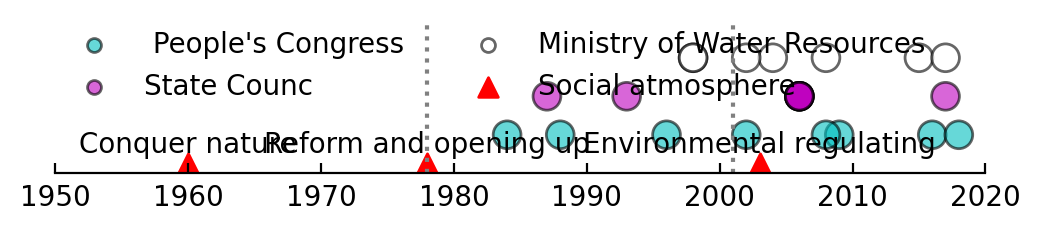

In [6]:
policy = pd.read_excel(cfg.db.policy)


def div_levels(x):
    if x == "National People's Congress of the PRC":
        return 3
    elif x == "State Council of the PRC":
        return 2
    elif x == "Ministry of Water Resources of the PRC":
        return 1


policy["level"] = policy["agency"].apply(div_levels)

events = pd.read_csv(cfg.db.events, index_col=0)
frequency = events.groupby("Year").count()["Title"].loc[1950:2015]


def plot_time_line(ax=False):
    alpha = 0.6
    if not ax:
        fig, ax = plt.subplots(figsize=(6, 1))

    colors = ["c", "m", "white"]
    trans_color = "red"
    scale = 100
    ys = [-0.5, 0, 0.5]
    # 每个层级的点分别绘图
    for i, level in enumerate(policy["level"].unique()):
        data = policy[policy["level"] == level]
        x = data["施行or修订时间"].values
        y = np.ones(len(x)) * ys[i]
        s = np.ones(len(x)) * scale
        label = data["agency"].iloc[0].strip("of the PRC").strip("National")
        # label = {
        #     " People's Congress": "人大常委",
        #     "State Counc": "国务院",
        #     "Ministry of Water Resources": "水利部",
        # }[label]
        ax.scatter(
            x,
            y,
            color=colors[i],
            s=s,
            edgecolor="black",
            label=label,
            alpha=alpha,
        )

    # dates = policy['施行or修订时间']
    # ax.plot(dates, np.zeros_like(dates), "-.", zorder=-1, color='lightgray')
    # ax.hlines(0.8, 1965, 1978, color=colors[i])
    transformation = ax.scatter(
        1960,
        -1,
        s=scale * 2,
        color=trans_color,
        marker="^",
        label="Social atmosphere"
        # 1960, -1, s=scale * 2, color=trans_color, marker="^", label="社会背景"
    )

    ax.scatter(1978, -1, s=scale * 2, color=trans_color, marker="^", zorder=1)
    #     ax.scatter(1987, -1, s=scale*2, color=trans_color, marker='^', zorder=1)
    ax.scatter(2003, -1, s=scale * 2, color=trans_color, marker="^", zorder=1)
    ax.text(
        1960,
        -0.8,
        "Conquer nature",
        # "征服自然",
        horizontalalignment="center",
        verticalalignment="bottom",
    )
    ax.text(
        1978,
        -0.8,
        "Reform and opening up",
        # "改革开放",
        horizontalalignment="center",
        verticalalignment="bottom",
    )
    ax.text(
        2003,
        -0.8,
        "Environmental regulating",
        # "环境规制",
        horizontalalignment="center",
        verticalalignment="bottom",
    )

    ax.set_xlim(1950, 2020)
    ax.set_ylim(-1, 1)
    ax.set_yticks([])
    ax.axvline(1978, ls=":", color="gray")
    ax.axvline(2001, ls=":", color="gray")

    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.legend(
        loc="upper left",
        frameon=False,
        ncol=2,
        borderaxespad=0.0,
        markerscale=0.5,
    )


plot_time_line()

/var/folders/s9/w7bh_d6x1h915wcvpbp117tm0000gn/T/ipykernel_90856/2785820649.py:5: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.3)
/var/folders/s9/w7bh_d6x1h915wcvpbp117tm0000gn/T/ipykernel_90856/2785820649.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  city_yr.groupby(["Year"]).sum()["Irrigated area: Total"] / 1000,
/var/folders/s9/w7bh_d6x1h915wcvpbp117tm0000gn/T/ipykernel_90856/2785820649.py:41: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  city_yr.groupby(["Year"]).mean()[

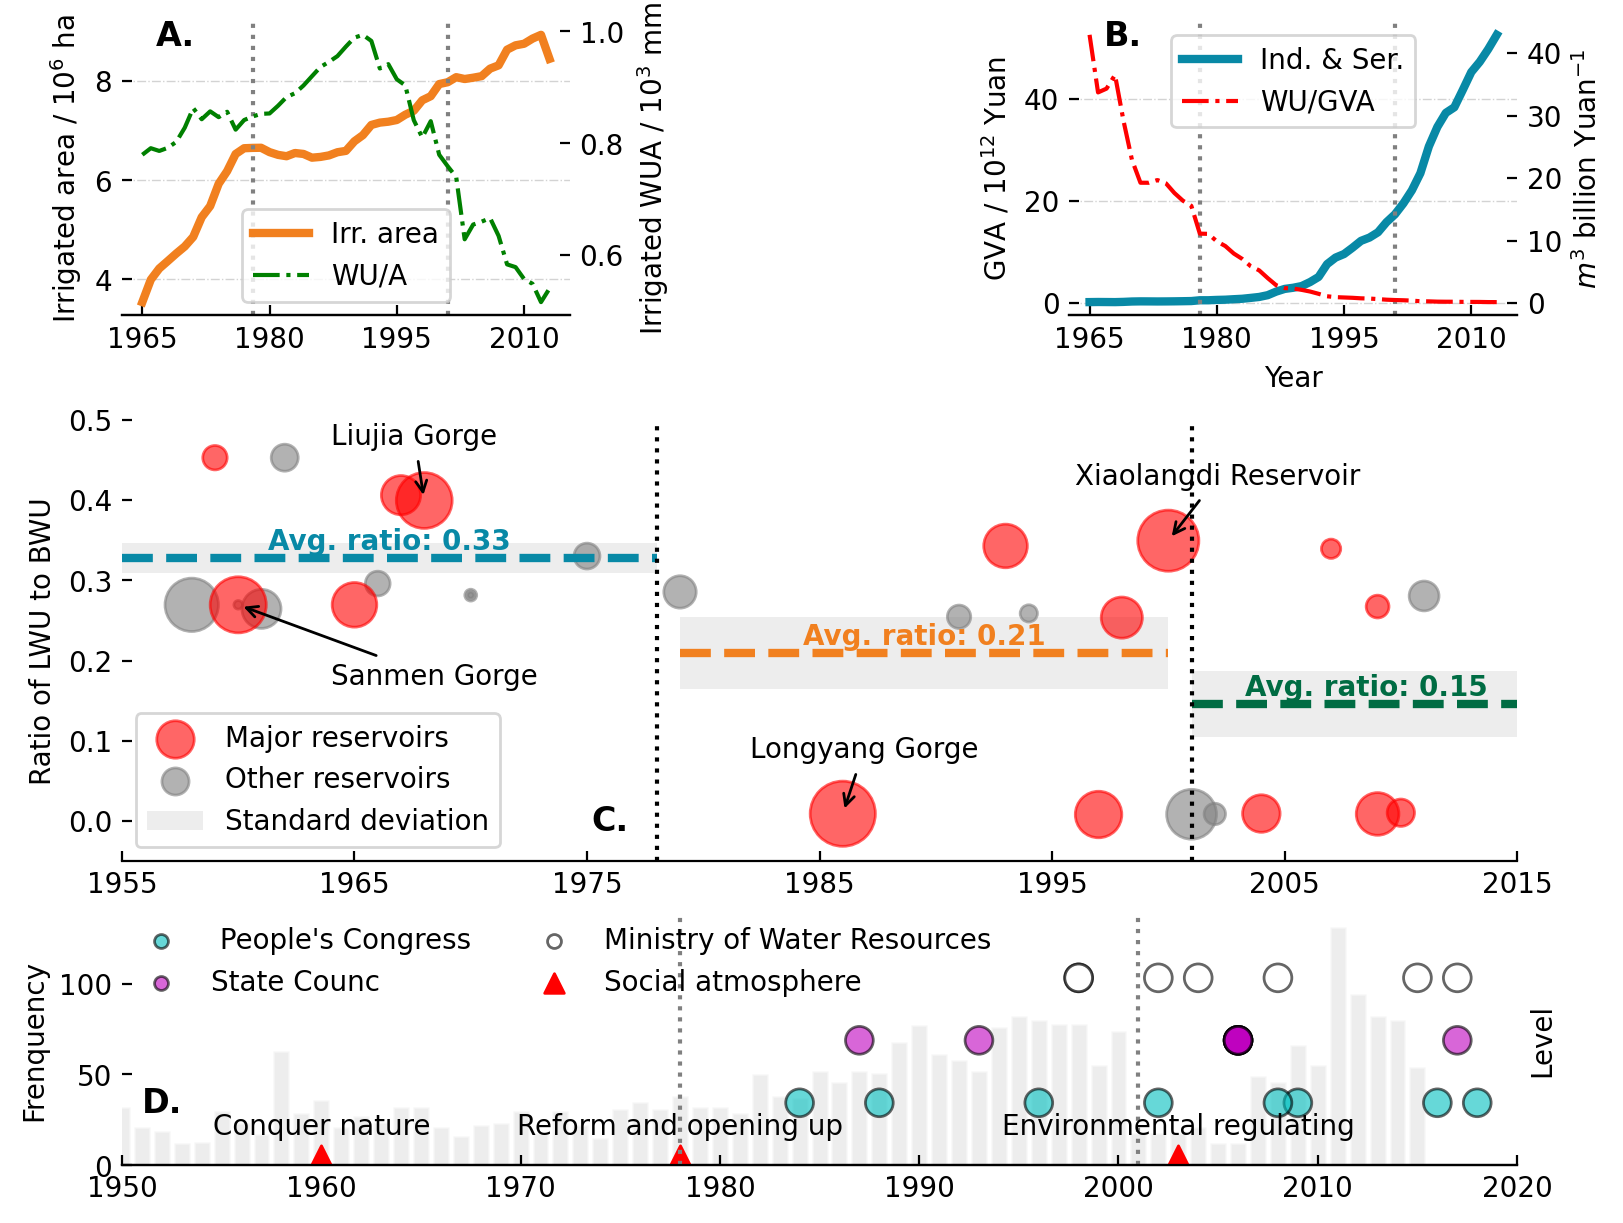

In [8]:
import seaborn as sns
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(8, 6), constrained_layout=True)
fig.subplots_adjust(wspace=0.3)
gs = GridSpec(3, 3, figure=fig, height_ratios=[2, 3, 1.7], width_ratios=[1, 0.01, 1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, -1])
# ax3 = fig.add_subplot(gs[1, :3])
ax4 = fig.add_subplot(gs[1, :])
ax5 = fig.add_subplot(gs[2, :])
ax6 = ax5.twinx()

gva_cols = [
    "Irrigated area: Total",
    "Industrial gross value added (GVA): Total",
    "Service GVA",
]
wui_cols = [
    "Irrigation water-use intensity (WUI): Total",
    "Industrial WUI: Total",
    "Service WUI",
]

size = 50  # 图1 和 图2 散点的大小
alpha = 0.2  # 图1 和 图2 散点的透明度

# 图1： =========================== 农业发展 ==================================

irrigation_area = ax1.plot(
    city_yr.groupby(["Year"]).sum()["Irrigated area: Total"] / 1000,
    color=period_colors[1],
    lw=3,
    # label="灌溉面积",
    label="Irr. area",
)

# 农业WUI
ax1_2 = ax1.twinx()
irrigation_wui = ax1_2.plot(
    city_yr.groupby(["Year"]).mean()["Irrigation water-use intensity (WUI): Total"]
    / 1000,
    ls="-.",
    color="green",
    # label="单位面积耗水",
    label="WU/A",
)

# ax1.set_xlabel("Year")
# ax1.set_ylabel("灌溉面积 / $10^6$ ha")
ax1.set_ylabel("Irrigated area / $10^6$ ha")

# ax1_2.set_ylabel("单位面积灌溉量 / $10^3$ mm")
ax1_2.set_ylabel("Irrigated WUA / $10^3$ mm")


# 图2： =========================== 工业服务业 ===================================
wui_mean = city_yr.groupby(["Year"]).sum()[wui_cols]


industry = ax2.plot(
    city_yr.groupby(["Year"])
    .sum()[["Industrial gross value added (GVA): Total", "Service GVA"]]
    .sum(axis=1)
    / 100,
    color=period_colors[0],
    lw=3,
    # label="工业服务业",
    label="Ind. & Ser.",
)
ax2_2 = ax2.twinx()
mean_wui = ax2_2.plot(
    wui_mean.iloc[:, 1:].mean(axis=1),
    "-.",
    color="red",
    # label="单位产值耗水",
    label="WU/GVA",
)

ax2.set_xlabel("Year")
# ax2.set_ylabel("区域总增加值 / 千亿元")
ax2.set_ylabel("GVA / $10^{12}$ Yuan")

# ax2_2.set_ylabel("单位产值用水强度 / $m^3$")
ax2_2.set_ylabel("$m^3$ billion Yuan$^{-1}$")

# ======= 图4 =========
plot_reservoirs(ax4)

# ======= 图5 =========
frequency = events.groupby("Year").count()["Title"].loc[1950:2015]
ax5.bar(
    frequency.index,
    frequency.values,
    color="lightgray",
    edgecolor="white",
    zorder=0,
    alpha=0.4,
)
plot_time_line(ax6)

# 修饰图片 ============
ax1.legend(handles=irrigation_area + irrigation_wui, loc="lower center")
ax2.legend(handles=industry + mean_wui, loc="upper center")
ax4.legend()

# 标签
from regimes_yrb.tools.processing import get_position_by_ratio
import matplotlib.ticker as ticker

x_r, y_r = 0.12, 0.95
x1, y1 = get_position_by_ratio(ax1, x_r, y_r)
x2, y2 = get_position_by_ratio(ax2, x_r, y_r)
ax1.text(x1, y1, "A.", ha="center", va="center", weight="bold", size="large")
ax2.text(x2, y2, "B.", ha="center", va="center", weight="bold", size="large")
# ax3.text(-0.2, 20, 'c.', ha='center', va='center', weight='bold', size='large')
ax4.text(1976, 0.0, "C.", ha="center", va="center", weight="bold", size="large")
ax6.text(1952, -0.5, "D.", ha="center", va="center", weight="bold", size="large")

# 坐标轴
plt.rcParams["xtick.direction"] = "in"  # in; out; inout
plt.rcParams["ytick.direction"] = "in"
ax1.axes.get_xaxis().set_visible(True)
for ax in [ax1, ax2]:
    ax.axvline(1978, ls=":", color="gray", lw=1.5)
    ax.axvline(2001, ls=":", color="gray", lw=1.5)
    ax.yaxis.grid(color="lightgray", linestyle="-.", linewidth=0.5)

for ax in [ax1, ax2, ax1_2, ax2_2, ax4, ax5, ax6]:
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(True)

for ax in [ax1, ax2, ax1_2, ax2_2]:
    ax.set_xticks(np.arange(1965, 2013, 15))

ax4.set_xticks(np.arange(1955, 2016, 10))
# ax5.set_ylabel("治理大事记频次")
ax5.set_ylabel("Frenquency")
ax6.set_ylabel("Level")

# 储存和显示图片
plt.savefig("figures/main/causes.pdf", dpi=300)
plt.savefig("figures/main/causes.jpg", dpi=300)
plt.show();